In [2]:
import pandas as pd

file_path = 'facility smart meter kw data.xlsx'

df = pd.read_excel(file_path)
df

,facility_id,datetime_beginning,kw_demand,temp_f,humidity,pressure_millibars
0,93a64e38-29c9-4e21-a5ca-7ea5fcd61144,2023-01-30 16:00:00,3.77,52.65,58,1013.3
1,93a64e38-29c9-4e21-a5ca-7ea5fcd61144,2023-01-30 17:00:00,3.54,50.83,59,1013.3
2,93a64e38-29c9-4e21-a5ca-7ea5fcd61144,2023-01-30 18:00:00,4.23,48.76,65,1014.3
3,93a64e38-29c9-4e21-a5ca-7ea5fcd61144,2023-01-30 19:00:00,3.47,47.76,65,1016.2
4,93a64e38-29c9-4e21-a5ca-7ea5fcd61144,2023-01-30 20:00:00,3.44,44.89,70,1015.3
...,...,...,...,...,...,...
8370,93a64e38-29c9-4e21-a5ca-7ea5fcd61144,2024-01-14 11:00:00,2.53,64.33,70,1017.1
8371,93a64e38-29c9-4e21-a5ca-7ea5fcd61144,2024-01-14 12:00:00,3.17,68.56,65,1015.8
8372,93a64e38-29c9-4e21-a5ca-7ea5fcd61144,2024-01-14 13:00:00,2.51,66.73,67,1015.0
8373,93a64e38-29c9-4e21-a5ca-7ea5fcd61144,2024-01-14 14:00:00,3.14,64.78,71,1014.3


In [3]:
# This function will allow you to calculate MAPE as sklearn.metrics doesn't have a native function for it.
# to use it, just call your actual and predicted values from your model's test set for example for the RF model we've been
# using it would be: mape_rf = mean_absolute_percentage_error(y_test, y_rf_pred)

def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

## 1) Find Opening days and hours 

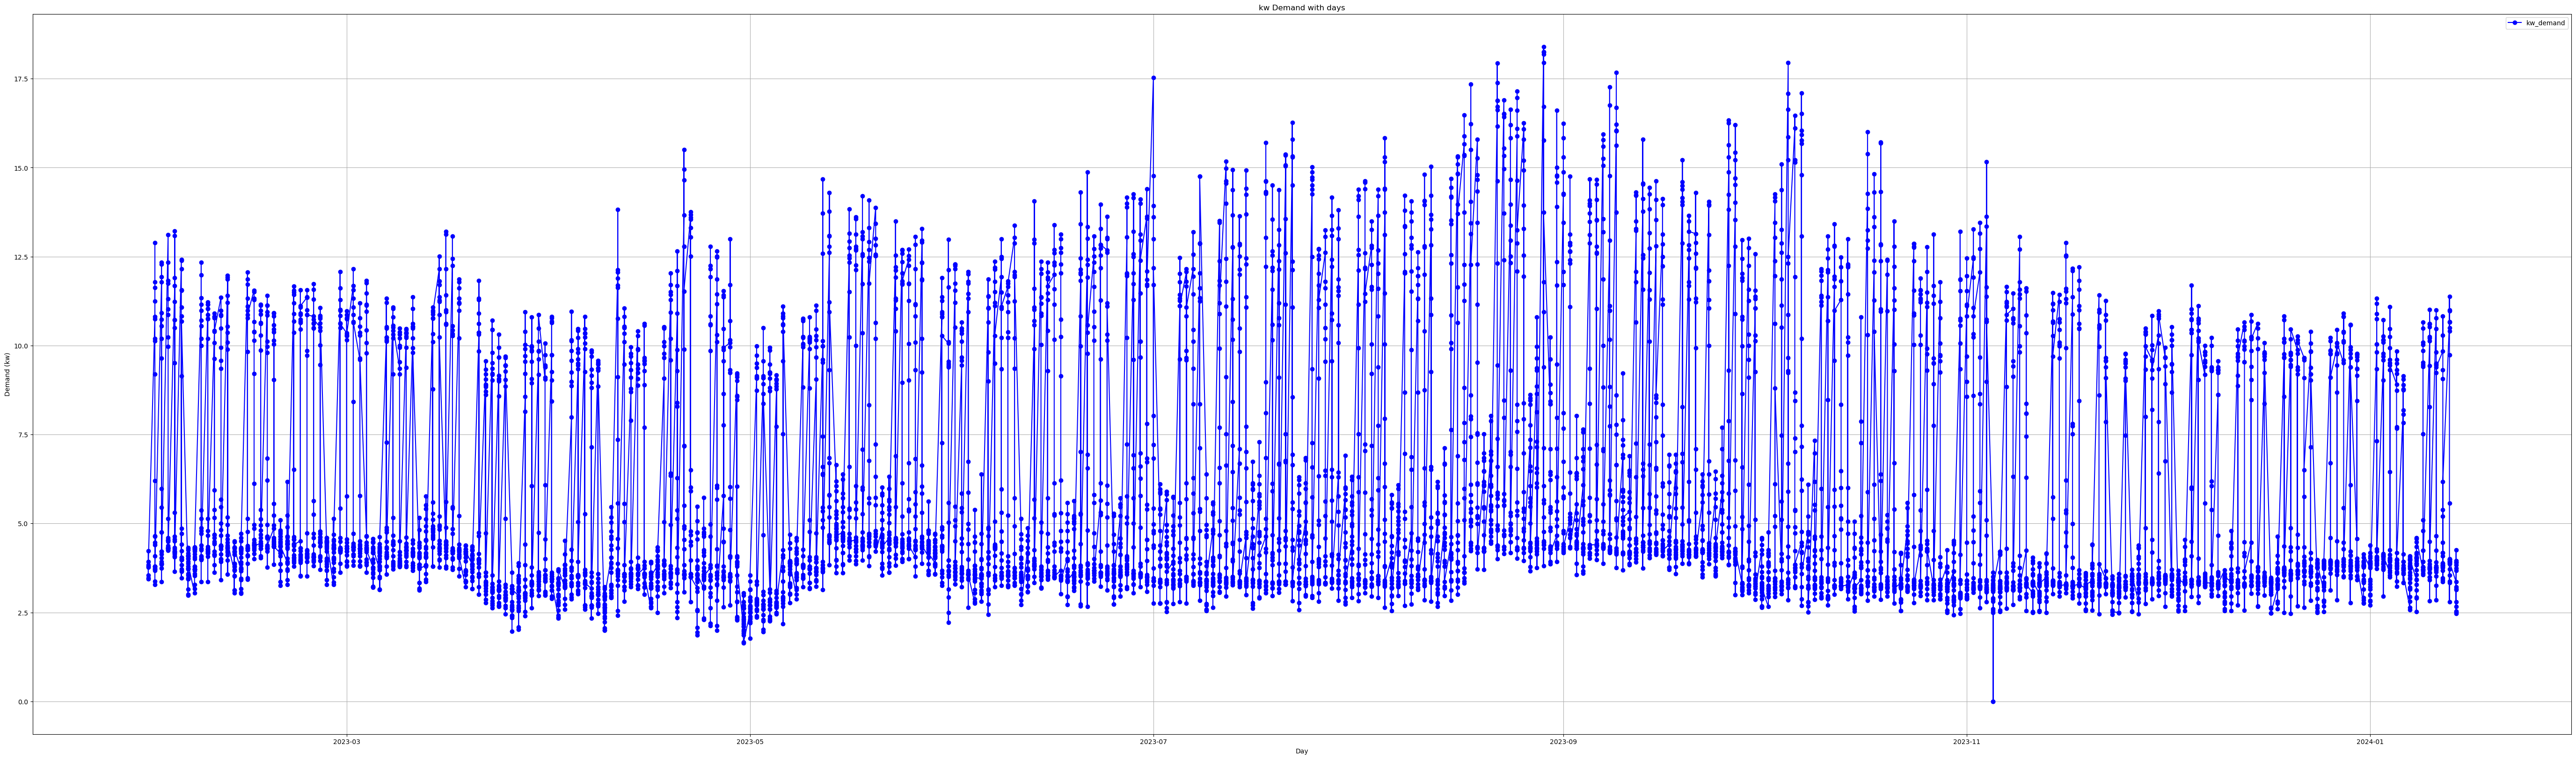

In [4]:
# Graph of Demand vs. Date
import matplotlib.pyplot as plt

df['Day'] = df['datetime_beginning'].dt.date
df.sort_values('Day', inplace=True)

plt.figure(figsize=(70, 20))
plt.plot(df['Day'], df['kw_demand'], label='kw_demand', color='blue', marker='o')

plt.title('kw Demand with days')
plt.xlabel('Day')
plt.ylabel('Demand (kw)')
plt.legend()
plt.grid(True)


C:\Users\zylia\AppData\Local\Temp\ipykernel_17072\908468904.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_recent['hour'] = df_recent['datetime_beginning'].dt.hour


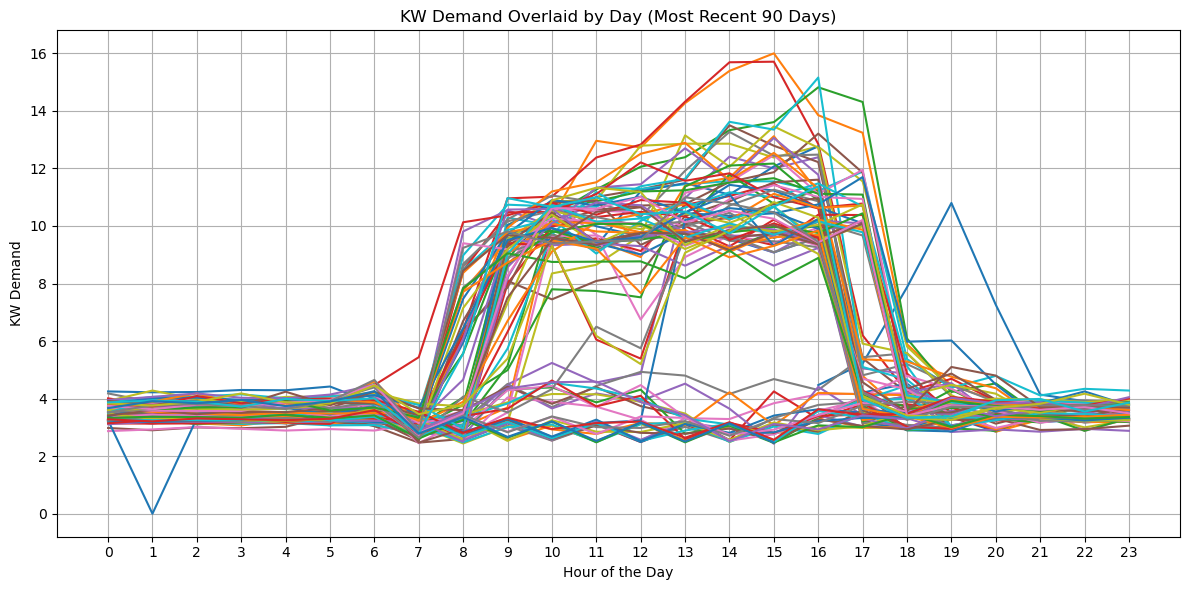

In [5]:
#plot the kw_demand data overlaid by day to see how consistent the demand curve is
import pandas as pd
import matplotlib.pyplot as plt

df_sorted = df.sort_values(by='datetime_beginning', ascending=False)

# Select the most recent 90 days of data
df_recent = df_sorted.head(24 * 90)

# Extract hour of the day
df_recent['hour'] = df_recent['datetime_beginning'].dt.hour

# Group by date
grouped = df_recent.groupby(df_recent['datetime_beginning'].dt.date)

plt.figure(figsize=(12, 6))

# Plotting each day's KW demand
for date, group in grouped:
    plt.plot(group['hour'], group['kw_demand'], label=str(date))

plt.xlabel('Hour of the Day')
plt.ylabel('KW Demand')
plt.title('KW Demand Overlaid by Day (Most Recent 90 Days)')
plt.grid(True)
plt.xticks(range(24))
plt.tight_layout()
plt.show()

In [6]:
threshold = 5.5
df_open = df
df_open['open'] = (df_open['kw_demand'] > threshold).astype(int)

# Extract day of the week and hour from datetime_beginning
df_open['Day_of_Week'] = df_open['datetime_beginning'].dt.dayofweek
df_open['Hour'] = df_open['datetime_beginning'].dt.hour

# Filter to keep only rows where the store is open
open_hours = df_open[df_open['open'] == 1]

# Group by day of the week and hour, and count occurrences
open_hours_count = open_hours.groupby(['Day_of_Week', 'Hour']).size().reset_index(name='Open_Count')

# Display the hours when the store is typically open
print(open_hours_count)

     Day_of_Week  Hour  Open_Count
0              0     9           1
1              0    10           1
2              0    11           6
3              0    12           9
4              0    13           7
..           ...   ...         ...
100            6    19           9
101            6    20           5
102            6    21           2
103            6    22           1
104            6    23           2

[105 rows x 3 columns]


## 2) Add Features to Model

In [7]:
# add Hour_of_Day as a value from 0 to 24
df_open['Hour_of_Day'] = df_open['datetime_beginning'].dt.hour
df_open

,facility_id,datetime_beginning,kw_demand,temp_f,humidity,pressure_millibars,Day,open,Day_of_Week,Hour,Hour_of_Day
0,93a64e38-29c9-4e21-a5ca-7ea5fcd61144,2023-01-30 16:00:00,3.77,52.65,58,1013.3,2023-01-30,0,0,16,16
1,93a64e38-29c9-4e21-a5ca-7ea5fcd61144,2023-01-30 17:00:00,3.54,50.83,59,1013.3,2023-01-30,0,0,17,17
2,93a64e38-29c9-4e21-a5ca-7ea5fcd61144,2023-01-30 18:00:00,4.23,48.76,65,1014.3,2023-01-30,0,0,18,18
3,93a64e38-29c9-4e21-a5ca-7ea5fcd61144,2023-01-30 19:00:00,3.47,47.76,65,1016.2,2023-01-30,0,0,19,19
4,93a64e38-29c9-4e21-a5ca-7ea5fcd61144,2023-01-30 20:00:00,3.44,44.89,70,1015.3,2023-01-30,0,0,20,20
...,...,...,...,...,...,...,...,...,...,...,...
8361,93a64e38-29c9-4e21-a5ca-7ea5fcd61144,2024-01-14 02:00:00,3.84,41.40,87,1018.2,2024-01-14,0,6,2,2
8359,93a64e38-29c9-4e21-a5ca-7ea5fcd61144,2024-01-14 00:00:00,3.67,43.49,81,1017.3,2024-01-14,0,6,0,0
8373,93a64e38-29c9-4e21-a5ca-7ea5fcd61144,2024-01-14 14:00:00,3.14,64.78,71,1014.3,2024-01-14,0,6,14,14
8365,93a64e38-29c9-4e21-a5ca-7ea5fcd61144,2024-01-14 06:00:00,4.26,42.62,89,1017.2,2024-01-14,0,6,6,6


In [8]:
# add Day_of_Week as a value from 0 to 6
df_open['Day_of_Week'] = df_open['datetime_beginning'].dt.dayofweek

df_open

,facility_id,datetime_beginning,kw_demand,temp_f,humidity,pressure_millibars,Day,open,Day_of_Week,Hour,Hour_of_Day
0,93a64e38-29c9-4e21-a5ca-7ea5fcd61144,2023-01-30 16:00:00,3.77,52.65,58,1013.3,2023-01-30,0,0,16,16
1,93a64e38-29c9-4e21-a5ca-7ea5fcd61144,2023-01-30 17:00:00,3.54,50.83,59,1013.3,2023-01-30,0,0,17,17
2,93a64e38-29c9-4e21-a5ca-7ea5fcd61144,2023-01-30 18:00:00,4.23,48.76,65,1014.3,2023-01-30,0,0,18,18
3,93a64e38-29c9-4e21-a5ca-7ea5fcd61144,2023-01-30 19:00:00,3.47,47.76,65,1016.2,2023-01-30,0,0,19,19
4,93a64e38-29c9-4e21-a5ca-7ea5fcd61144,2023-01-30 20:00:00,3.44,44.89,70,1015.3,2023-01-30,0,0,20,20
...,...,...,...,...,...,...,...,...,...,...,...
8361,93a64e38-29c9-4e21-a5ca-7ea5fcd61144,2024-01-14 02:00:00,3.84,41.40,87,1018.2,2024-01-14,0,6,2,2
8359,93a64e38-29c9-4e21-a5ca-7ea5fcd61144,2024-01-14 00:00:00,3.67,43.49,81,1017.3,2024-01-14,0,6,0,0
8373,93a64e38-29c9-4e21-a5ca-7ea5fcd61144,2024-01-14 14:00:00,3.14,64.78,71,1014.3,2024-01-14,0,6,14,14
8365,93a64e38-29c9-4e21-a5ca-7ea5fcd61144,2024-01-14 06:00:00,4.26,42.62,89,1017.2,2024-01-14,0,6,6,6


In [9]:
# add season where winter (Dec, Jan, Feb) is 1, spring (Mar, Apr, May) is 2, summer (June, July, Aug) is 3, and fall (Sep, Oct, Nov) is 4.
df_open['Season'] = df_open['datetime_beginning'].dt.month%12 // 3 + 1
df_open

,facility_id,datetime_beginning,kw_demand,temp_f,humidity,pressure_millibars,Day,open,Day_of_Week,Hour,Hour_of_Day,Season
0,93a64e38-29c9-4e21-a5ca-7ea5fcd61144,2023-01-30 16:00:00,3.77,52.65,58,1013.3,2023-01-30,0,0,16,16,1
1,93a64e38-29c9-4e21-a5ca-7ea5fcd61144,2023-01-30 17:00:00,3.54,50.83,59,1013.3,2023-01-30,0,0,17,17,1
2,93a64e38-29c9-4e21-a5ca-7ea5fcd61144,2023-01-30 18:00:00,4.23,48.76,65,1014.3,2023-01-30,0,0,18,18,1
3,93a64e38-29c9-4e21-a5ca-7ea5fcd61144,2023-01-30 19:00:00,3.47,47.76,65,1016.2,2023-01-30,0,0,19,19,1
4,93a64e38-29c9-4e21-a5ca-7ea5fcd61144,2023-01-30 20:00:00,3.44,44.89,70,1015.3,2023-01-30,0,0,20,20,1
...,...,...,...,...,...,...,...,...,...,...,...,...
8361,93a64e38-29c9-4e21-a5ca-7ea5fcd61144,2024-01-14 02:00:00,3.84,41.40,87,1018.2,2024-01-14,0,6,2,2,1
8359,93a64e38-29c9-4e21-a5ca-7ea5fcd61144,2024-01-14 00:00:00,3.67,43.49,81,1017.3,2024-01-14,0,6,0,0,1
8373,93a64e38-29c9-4e21-a5ca-7ea5fcd61144,2024-01-14 14:00:00,3.14,64.78,71,1014.3,2024-01-14,0,6,14,14,1
8365,93a64e38-29c9-4e21-a5ca-7ea5fcd61144,2024-01-14 06:00:00,4.26,42.62,89,1017.2,2024-01-14,0,6,6,6,1


## 3) Building ML Model

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

X = df_open[['temp_f', 'humidity', 'pressure_millibars', 'open','Day_of_Week','Season','Hour_of_Day']]
y = df_open['kw_demand']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# naive baseline
y_train_median = y_train.median()
y_naive_pred = np.full(shape=y_test.shape, fill_value=y_train_median)
mae_naive = mean_absolute_error(y_test, y_naive_pred)
mse_naive = mean_squared_error(y_test, y_naive_pred)
rmse_naive = np.sqrt(mse_naive)
mape_naive = mean_absolute_percentage_error(y_test, y_naive_pred)
# linear regression
from sklearn.linear_model import LinearRegression
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)
y_pred = linear_model.predict(X_test)
mae_linear = mean_absolute_error(y_test, y_pred)
mse_linear = mean_squared_error(y_test, y_pred)
rmse_linear = np.sqrt(mse_linear)
mape_linear = mean_absolute_percentage_error(y_test, y_pred)
# random forest
from sklearn.ensemble import RandomForestRegressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_rf_pred = rf_model.predict(X_test)
mae_rf = mean_absolute_error(y_test, y_rf_pred)
mse_rf = mean_squared_error(y_test, y_rf_pred)
rmse_rf = np.sqrt(mse_rf)
mape_rf = mean_absolute_percentage_error(y_test, y_rf_pred)
# SVR model
from sklearn.svm import SVR
svr_model = SVR(kernel='rbf', C=1.0, epsilon=0.1)
svr_model.fit(X_train, y_train)
y_svr_pred = svr_model.predict(X_test)
mae_svr = mean_absolute_error(y_test, y_svr_pred)
mse_svr = mean_squared_error(y_test, y_svr_pred)
rmse_svr = np.sqrt(mse_svr)
mape_svr = mean_absolute_percentage_error(y_test, y_svr_pred)
# gradient boosting regressor
from sklearn.ensemble import GradientBoostingRegressor
gbr_model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
gbr_model.fit(X_train, y_train)
y_gbr_pred = gbr_model.predict(X_test)
mae_gbr = mean_absolute_error(y_test, y_gbr_pred)
mse_gbr = mean_squared_error(y_test, y_gbr_pred)
rmse_gbr = np.sqrt(mse_gbr)
mape_gbr = mean_absolute_percentage_error(y_test, y_gbr_pred)
# KNeighbors regressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
knn_model = KNeighborsRegressor(n_neighbors=5)
knn_model.fit(X_train_scaled, y_train)
y_knn_pred = knn_model.predict(X_test_scaled)
mae_knn = mean_absolute_error(y_test, y_knn_pred)
mse_knn = mean_squared_error(y_test, y_knn_pred)
rmse_knn = np.sqrt(mse_knn)
mape_knn = mean_absolute_percentage_error(y_test, y_knn_pred)
# results
results1 = {
    'Model': ['Naive Baseline', 'Linear Regression', 'Random Forest', 'SVR', 'Gradient Boosting', 'KNN'],
    'MAE': [mae_naive, mae_linear, mae_rf, mae_svr, mae_gbr, mae_knn],
    'MSE': [mse_naive, mse_linear, mse_rf, mse_svr, mse_gbr, mse_knn],
    'RMSE': [rmse_naive, rmse_linear, rmse_rf, rmse_svr, rmse_gbr, rmse_knn],
    'MAPE': [mape_naive, mape_linear, mape_rf, mape_svr, mape_gbr, mape_knn]
}
results1_df = pd.DataFrame(results1)
results1_df.set_index('Model', inplace=True)
results1_df_sorted_by_mape = results1_df.sort_values(by='MAPE', ascending=True)

print(results1_df_sorted_by_mape)

                        MAE        MSE      RMSE       MAPE
Model                                                      
Random Forest      0.502733   0.599764  0.774444   9.227081
KNN                0.590872   0.991137  0.995559  10.408674
Gradient Boosting  0.627088   0.807658  0.898698  11.806041
Linear Regression  0.954246   2.154955  1.467976  16.978969
SVR                2.076735  10.661601  3.265211  29.804832
Naive Baseline     2.263188  13.401367  3.660788  30.552178


In [11]:
# choose Random Forest model

## 4) Prediction using the weather data

In [12]:
file_path2 = 'facility weather forecast for DR event.xlsx'

df2 = pd.read_excel(file_path2)
df2

,facility_id,datetime_beginning,temp_f,humidity,pressure_millibars
0,0835fe8e-ea64-400c-8c22-d1f5f8de557c,2024-01-14 16:00:00,58.66,83,1015.3
1,0835fe8e-ea64-400c-8c22-d1f5f8de557c,2024-01-14 17:00:00,56.52,86,1015.2
2,0835fe8e-ea64-400c-8c22-d1f5f8de557c,2024-01-14 18:00:00,55.35,89,1015.3
3,0835fe8e-ea64-400c-8c22-d1f5f8de557c,2024-01-14 19:00:00,53.87,91,1015.8
4,0835fe8e-ea64-400c-8c22-d1f5f8de557c,2024-01-14 20:00:00,53.21,91,1016.3
...,...,...,...,...,...
139,0835fe8e-ea64-400c-8c22-d1f5f8de557c,2024-01-20 11:00:00,56.77,95,1010.3
140,0835fe8e-ea64-400c-8c22-d1f5f8de557c,2024-01-20 12:00:00,58.54,90,1009.8
141,0835fe8e-ea64-400c-8c22-d1f5f8de557c,2024-01-20 13:00:00,59.58,87,1009.2
142,0835fe8e-ea64-400c-8c22-d1f5f8de557c,2024-01-20 14:00:00,60.60,83,1008.3


In [18]:
# add Hour_of_Day as a value from 0 to 24
df2['Hour_of_Day'] = df2['datetime_beginning'].dt.hour
# add Day_of_Week as a value from 0 to 6
df2['Day_of_Week'] = df2['datetime_beginning'].dt.dayofweek
# add season where winter (Dec, Jan, Feb) is 1, spring (Mar, Apr, May) is 2, summer (June, July, Aug) is 3, and fall (Sep, Oct, Nov) is 4.
df2['Season'] = df2['datetime_beginning'].dt.month%12 // 3 + 1
df2

,facility_id,datetime_beginning,temp_f,humidity,pressure_millibars,Hour_of_Day,Day_of_Week,Season,open
0,0835fe8e-ea64-400c-8c22-d1f5f8de557c,2024-01-14 16:00:00,58.66,83,1015.3,16,6,1,0
1,0835fe8e-ea64-400c-8c22-d1f5f8de557c,2024-01-14 17:00:00,56.52,86,1015.2,17,6,1,0
2,0835fe8e-ea64-400c-8c22-d1f5f8de557c,2024-01-14 18:00:00,55.35,89,1015.3,18,6,1,0
3,0835fe8e-ea64-400c-8c22-d1f5f8de557c,2024-01-14 19:00:00,53.87,91,1015.8,19,6,1,0
4,0835fe8e-ea64-400c-8c22-d1f5f8de557c,2024-01-14 20:00:00,53.21,91,1016.3,20,6,1,0
...,...,...,...,...,...,...,...,...,...
139,0835fe8e-ea64-400c-8c22-d1f5f8de557c,2024-01-20 11:00:00,56.77,95,1010.3,11,5,1,1
140,0835fe8e-ea64-400c-8c22-d1f5f8de557c,2024-01-20 12:00:00,58.54,90,1009.8,12,5,1,1
141,0835fe8e-ea64-400c-8c22-d1f5f8de557c,2024-01-20 13:00:00,59.58,87,1009.2,13,5,1,1
142,0835fe8e-ea64-400c-8c22-d1f5f8de557c,2024-01-20 14:00:00,60.60,83,1008.3,14,5,1,1


In [19]:
#Concatenate "open" column
df2['open'] = ((df2['Day_of_Week'] >= 1) & 
               (df2['Day_of_Week'] <= 5) & 
               (df2['Hour_of_Day'] >= 8) &
               (df2['Hour_of_Day']<= 17)).astype(int)
df2.to_excel("df2.xlsx")

In [26]:
df2_base = df2.loc[((df2['datetime_beginning'].dt.date >= pd.Timestamp('2024-01-16').date()) & 
                    (df2['datetime_beginning'].dt.date <= pd.Timestamp('2024-01-19').date()))]
df2_base.to_excel("df2_base.xlsx")

df2_adjusted = df2_base.copy()
filtered_index = ((df2_adjusted['datetime_beginning'].dt.hour >= 8) & (df2_adjusted['datetime_beginning'].dt.hour <= 10) |
                  (df2_adjusted['datetime_beginning'].dt.hour >= 14) & (df2_adjusted['datetime_beginning'].dt.hour <= 17))
df2_adjusted.loc[filtered_index, 'open'] = 0
df2_adjusted.to_excel("df2_adjusted.xlsx")

In [27]:
X_test_base = df2_base[['temp_f', 'humidity', 'pressure_millibars','open','Day_of_Week','Season','Hour_of_Day']]
X_test_adjusted = df2_adjusted[['temp_f', 'humidity', 'pressure_millibars','open','Day_of_Week','Season','Hour_of_Day']]

y_rf_pred_base = rf_model.predict(X_test_base)
y_rf_pred_adjusted = rf_model.predict(X_test_adjusted)

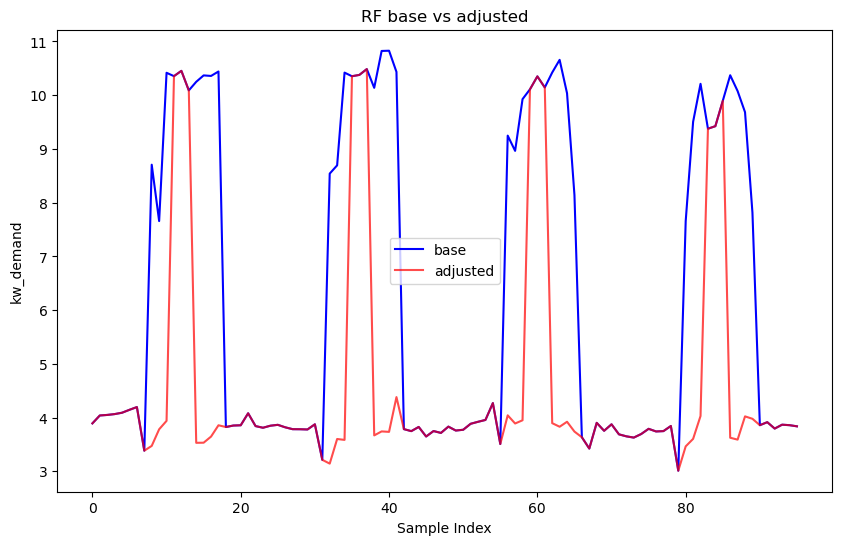

In [28]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(y_rf_pred_base, label='base', color='blue')
plt.plot(y_rf_pred_adjusted, label='adjusted', color='red', alpha=0.7)
plt.title(f'RF base vs adjusted')
plt.xlabel('Sample Index')
plt.ylabel('kw_demand')
plt.legend()
plt.show()

## 5) Calculate kwh and cost reduction

In [29]:
kwh_reduction = y_rf_pred_base - y_rf_pred_adjusted
kwh_reduction

array([0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
       5.2326, 3.8747, 6.477 , 0.    , 0.    , 0.    , 6.718 , 6.8351,
       6.7111, 6.5835, 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
       0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
       5.3968, 5.0927, 6.8345, 0.    , 0.    , 0.    , 6.4678, 7.0799,
       7.0926, 6.0514, 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
       0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
       5.2051, 5.0735, 5.9762, 0.    , 0.    , 0.    , 6.5252, 6.8274,
       6.1133, 4.4008, 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
       0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
       4.1913, 5.9006, 6.1817, 0.    , 0.    , 0.    , 6.7456, 6.4865,
       5.6606, 3.8368, 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ])

In [32]:
rev = kwh_reduction * 100
revenue = rev.sum()
hours = 7*4
cost = hours * 500
difference = revenue - cost
print('Revenue is ', revenue, ';cost is ', cost, ';difference is ', difference,'.' )

if difference > 0:
    print('It is better participate')
else:
    print('It is better not participate')

Revenue is  16557.229999999996 ;cost is  14000 ;difference is  2557.229999999996 .
It is better participate
